# Machine Learning Final Exam -  Decision Tree

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [179]:
df_full = pd.read_csv('Habitable_Full_Balanced.csv')
df_train = pd.read_csv('Habitable_Train_Balanced.csv')
df_test = pd.read_csv('Habitable_Test.csv')
df_val = pd.read_csv('Habitable_Val.csv')

In [180]:
print(f"Value counts for df_full:\n{df_full['Habitable'].value_counts()}\n")
print(f"Value counts for df_train:\n{df_train['Habitable'].value_counts()}\n")
print(f"Value counts for df_test:\n{df_test['Habitable'].value_counts()}\n")
print(f"Value counts for df_val:\n{df_val['Habitable'].value_counts()}\n")


Value counts for df_full:
Habitable
0    5145
1    1544
Name: count, dtype: int64

Value counts for df_train:
Habitable
0    3608
1    1082
Name: count, dtype: int64

Value counts for df_test:
Habitable
0    770
1     12
Name: count, dtype: int64

Value counts for df_val:
Habitable
0    767
1     14
Name: count, dtype: int64



**Preparation:**

Four files were imported. A training file that was already balanced in advance with synthetic data by SMOTE and a test and validation file, both of which contain the original, unbalanced data so as not to generate bias. In addition, an entire file containing balanced data using SMOTE was imported, which is used to perform cross validation. 

## Overview of Decision Tree Model


In [184]:
model= DecisionTreeClassifier()

In [185]:
print('Parameters currently in use:\n')
for param, value in model.get_params().items():
    print(f"{param}: {value}")

Parameters currently in use:

ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
random_state: None
splitter: best


### Overview of Decision Tree Parameters:

**ccp_alpha:** This is the complexity parameter used for Minimal Cost-Complexity Pruning (CCP). It specifies the non-negative cost complexity parameter of the Decision Tree. Increasing ccp_alpha increases the pruning strength, potentially resulting in a simpler tree that generalizes better to unseen data.


**class_weight:** This parameter allows you to specify weights for each class in the input data. It can be used to address class imbalance by giving more weight to minority classes, thereby affecting the impurity calculation during tree construction and potentially improving model performance on imbalanced datasets.

**criterion:** This specifies the function to measure the quality of a split. It can take two values: 'gini' for the Gini impurity and 'entropy' for the information gain. These criteria determine how the decision tree selects the best feature to split on at each node.


**max_depth:** This parameter specifies the maximum depth of the decision tree. If set to None (default), nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.


**max_features:** This parameter specifies the number of features to consider when looking for the best split. It can take various values like 'auto', 'sqrt', 'log2', or an integer. If set to None (default), all features will be considered for splitting at each node.


**max_leaf_nodes:** This parameter specifies the maximum number of leaf nodes in the decision tree. If set, the tree will be pruned such that it has no more than this number of leaf nodes.


**min_impurity_decrease:** This parameter specifies a threshold for early stopping of tree growth. A split will only be considered if it induces a decrease of the impurity greater than or equal to this value.


**min_samples_leaf:** This parameter specifies the minimum number of samples required to be at a leaf node. If set to an integer, it ensures that each leaf node has at least that number of samples.


**min_samples_split:** This parameter specifies the minimum number of samples required to split an internal node. If set to an integer, it ensures that a node is split only if it contains at least that number of samples.


**min_weight_fraction_leaf:** This parameter specifies the minimum weighted fraction of the total number of samples required to be at a leaf node. It works similarly to min_samples_leaf, but the samples are weighted.


**random_state:** This parameter sets the seed for random number generation. It ensures reproducibility of the results.


**splitter:** This parameter specifies the strategy used to choose the split at each node. It can take two values: 'best' to choose the best split based on the selected criterion, or 'random' to choose the best random split.

## 1. Default Model - All Features

In [186]:
# Define features (X) and target (y)
X_train = df_train.drop(columns=['Habitable'])
y_train = df_train['Habitable']


X_test = df_test.drop(columns=['Habitable'])
y_test = df_test['Habitable']

X_val = df_val.drop(columns=['Habitable'])
y_val = df_val['Habitable']

In [187]:
model_default= DecisionTreeClassifier(random_state=42)
model_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [188]:
# Print classification report for training set
y_train_pred = model_default.predict(X_train)
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))

Training set classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690



In [189]:
# Print classification report for validation set
y_val_pred = model_default.predict(X_val)
print("Validation set classification report:")
print(classification_report(y_val, y_val_pred))

Validation set classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.38      0.43      0.40        14

    accuracy                           0.98       781
   macro avg       0.68      0.71      0.69       781
weighted avg       0.98      0.98      0.98       781



**Perfrom Cross-Validation:**

In [377]:
# K-fold cross-validation
X_full = df_full.drop(columns=['Habitable'])
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Decision Tree Classifier 
model= DecisionTreeClassifier(random_state=42)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)
    
    
    print(f'For fold {fold}, we look on the macro avg:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print()

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix:\n{cm}\n')

    

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

For fold 1, we look on the macro avg:
Accuracy: 0.9820627802690582
Precision: 0.9779439835080932
Recall: 0.9714290197062885
F1 Score: 0.974636433430116

Confusion Matrix:
[[1019    9]
 [  15  295]]

For fold 2, we look on the macro avg:
Accuracy: 0.9790732436472347
Precision: 0.9672304506087612
Recall: 0.9736873918354881
F1 Score: 0.9704091723351352

Confusion Matrix:
[[1017   17]
 [  11  293]]

For fold 3, we look on the macro avg:
Accuracy: 0.9865470852017937
Precision: 0.9820831433348534
Recall: 0.9798827386206027
F1 Score: 0.980977325072587

Confusion Matrix:
[[1022    8]
 [  10  298]]

For fold 4, we look on the macro avg:
Accuracy: 0.9872944693572496
Precision: 0.9792851953541473
Recall: 0.9848124300111982
F1 Score: 0.9820135550707367

Confusion Matrix:
[[1023   11]
 [   6  298]]

For fold 5, we look on the macro avg:
Accuracy: 0.9798055347793567
Precision: 0.9689054423837032
Recall: 0.9759352182741743
F1 Score: 0.9723576936948526

Confusion Matrix:
[[1002   17]
 [  10  308]]

Me

**Results:**
While the model demonstrates high accuracy on the training set, it struggles with generalization, as evidenced by the lower precision, recall, and F1 scores on the validation set and during cross-validation. This is expected in highly imbalanced datasets, where the model tends to favor the majority class and may struggle to accurately predict the minority class. 

## 2. Complexity Reduction

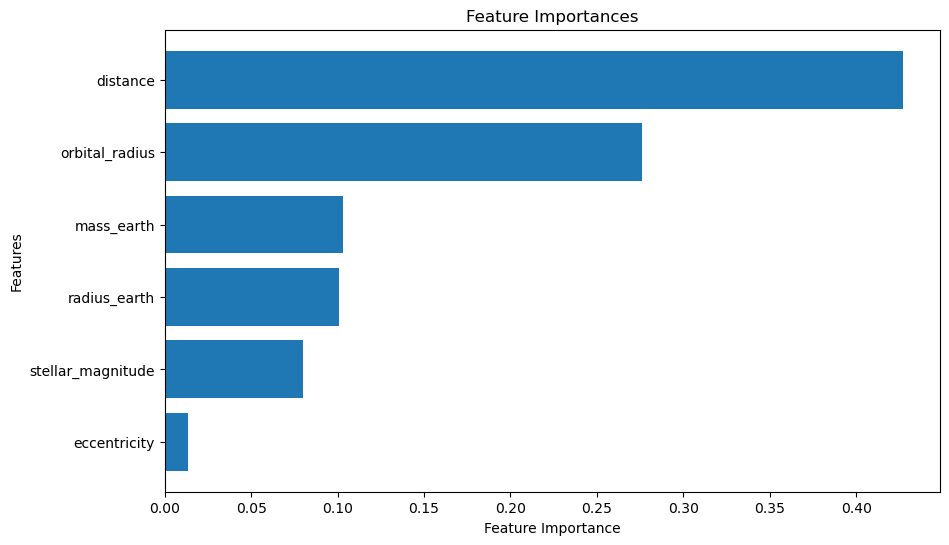

In [193]:
# Get feature importances
importances = model_default.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances[indices], align='center')
plt.yticks(range(len(features)), np.array(features)[indices])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()


**Results:**

Analyzing the importance of the individual features in the decision tree model, we can see that some features have a greater influence on the classification than others. In particular, the features "Distance" and "Orbital_Earth" have a strong influence on the model, followed by "Mass Earth", "Radius Earth" and "Stellar Magnitude". 
The next step is to check how the model behaves when the complexity is reduced. 

### Selecting the top 5 Features:

In [370]:
# Define features (X) and target (y)
X_train_5 = df_train[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_train_5 = df_train['Habitable']

X_test_5 = df_test[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_test_5 = df_test['Habitable']

X_val_5 = df_val[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_val_5 = df_val['Habitable']

In [371]:
model_five_features= DecisionTreeClassifier(random_state=42)
model_five_features.fit(X_train_5, y_train_5)

DecisionTreeClassifier(random_state=42)

In [372]:
# Print classification report for training set
y_train_pred_5 = model_five_features.predict(X_train_5)
print("Training set classification report:")
print(classification_report(y_train_5, y_train_pred_5))

Training set classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690



In [197]:
# Print classification report for validation set
y_val_pred_5 = model_five_features.predict(X_val_5)
print("Validation set classification report:")
print(classification_report(y_val_5, y_val_pred_5))

Validation set classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.41      0.50      0.45        14

    accuracy                           0.98       781
   macro avg       0.70      0.74      0.72       781
weighted avg       0.98      0.98      0.98       781



**Perform Cross-Validation:**

In [378]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Decision Tree Classifier 
model= DecisionTreeClassifier(random_state=42)


# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9832560235138124
Mean Macro Precision across all folds: 0.9744511141707222
Mean Macro Recall across all folds: 0.9786795899451987
Mean Macro F1 Score across all folds: 0.9765242241110277


### Selecting the top 4 Features:

In [200]:
# Define features (X) and target (y)
X_train_4 = df_train[['distance', 'orbital_radius', 'mass_earth', 'radius_earth']]
y_train_4 = df_train['Habitable']

X_test_4 = df_test[['distance', 'orbital_radius', 'mass_earth', 'radius_earth']]
y_test_4 = df_test['Habitable']

X_val_4 = df_val[['distance', 'orbital_radius', 'mass_earth', 'radius_earth']]
y_val_4 = df_val['Habitable']

In [201]:
model_four_features= DecisionTreeClassifier(random_state=42)
model_four_features.fit(X_train_4, y_train_4)

DecisionTreeClassifier(random_state=42)

In [202]:
# Print classification report for training set
y_train_pred_4 = model_four_features.predict(X_train_4)
print("Training set classification report:")
print(classification_report(y_train_4, y_train_pred_4))

Training set classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690



In [203]:
# Print classification report for validation set
y_val_pred_4 = model_four_features.predict(X_val_4)
print("Validation set classification report:")
print(classification_report(y_val_4, y_val_pred_4))

Validation set classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.44      0.50      0.47        14

    accuracy                           0.98       781
   macro avg       0.71      0.74      0.73       781
weighted avg       0.98      0.98      0.98       781



**Perform Cross-Validation:**

In [379]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5)

# Initialize Decision Tree Classifier 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.972042913378344
Mean Macro Precision across all folds: 0.9591296474169428
Mean Macro Recall across all folds: 0.9625784855324573
Mean Macro F1 Score across all folds: 0.9608257995356029


### Selecting the top 3 Features:

In [206]:
# Define features (X) and target (y)
X_train_3 = df_train[['distance', 'orbital_radius', 'mass_earth']]
y_train_3 = df_train['Habitable']

X_test_3 = df_test[['distance', 'orbital_radius', 'mass_earth']]
y_test_3 = df_test['Habitable']

X_val_3 = df_val[['distance', 'orbital_radius', 'mass_earth']]
y_val_3 = df_val['Habitable']

In [207]:
model_three_features= DecisionTreeClassifier(random_state=42)
model_three_features.fit(X_train_3, y_train_3)

DecisionTreeClassifier(random_state=42)

In [208]:
# Print classification report for training set
y_train_pred_3 = model_three_features.predict(X_train_3)
print("Training set classification report:")
print(classification_report(y_train_3, y_train_pred_3))

Training set classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690



In [209]:
# Print classification report for validation set
y_val_pred_3 = model_three_features.predict(X_val_3)
print("Validation set classification report:")
print(classification_report(y_val_3, y_val_pred_3))

Validation set classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       767
           1       0.28      0.50      0.36        14

    accuracy                           0.97       781
   macro avg       0.64      0.74      0.67       781
weighted avg       0.98      0.97      0.97       781



**Perform Cross-Validation:**

In [380]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Decision Tree Classifier 
model= DecisionTreeClassifier(random_state=42)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9680067035383637
Mean Macro Precision across all folds: 0.9525053728534829
Mean Macro Recall across all folds: 0.9581738911549957
Mean Macro F1 Score across all folds: 0.9552783920693562


### Model Selection: 

In evaluating the decision tree models with varying complexities resulting from different feature selections, several key observations emerge. Notably, when reducing the dimensionality of the feature space, we observe a notable improvement in precision, recall, and F1-score across the models with 5 and 4 features. This suggests that simplifying the model's input features leads to a more focused and effective decision-making process. On the other hand, when reducing the model's complexity too much (e.g. as seen with the 3 features), the performance decreases compared to the default model. 

Of particular significance is the performance of the model utilizing  five features. Despite the reduction in feature space, this model consistently achieves a high precision, recall, and F1-scores throughout all sets while maintaining a commendable level of accuracy. This outcome underscores the importance of feature selection in optimizing the model's predictive capabilities.



## 3. Model Pruning

## 3.1 Class Weights
This parameter allows you to specify weights for each class in the input data. It can be used to address class imbalance by giving more weight to minority classes, thereby affecting the impurity calculation during tree construction and potentially improving model performance on imbalanced datasets.

In [211]:
param_grid = {
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 5}, {0: 1, 1: 10}]  
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)



Best Parameters: {'class_weight': {0: 1, 1: 5}}


### 3.1.1 Class Weight Ratio: 1:2

In [213]:
# Define the weight ratio (1:2 for minority:majority class)
weight_ratio = {0: 1, 1: 2}

# Initialize Decision Tree Classifier with the specified weight ratio
model_1_to_2 = DecisionTreeClassifier(random_state=42, class_weight=weight_ratio)

# Fit the model on the full training data
model_1_to_2.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_1_to_2 = model_1_to_2.predict(X_val_5)

# Print classification report for train set using the model with 1:2 weight ratio
print("Training set classification report with 1:2 weight ratio:")
print(classification_report(y_train_5, y_train_pred_5))

# Print classification report for validation set using the model with 1:2 weight ratio
print("Validation set classification report with 1:2 weight ratio:")
print(classification_report(y_val_5, y_val_pred_1_to_2))

Training set classification report with 1:2 weight ratio:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with 1:2 weight ratio:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.44      0.50      0.47        14

    accuracy                           0.98       781
   macro avg       0.71      0.74      0.73       781
weighted avg       0.98      0.98      0.98       781



In [381]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Define the weight ratio (1:2 for minority:majority class)
weight_ratio = {0: 1, 1: 2}

# Initialize Decision Tree Classifier with the specified weight ratio
model = DecisionTreeClassifier(random_state=42, class_weight=weight_ratio)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9850495218865609
Mean Macro Precision across all folds: 0.97721454165693
Mean Macro Recall across all folds: 0.9809908558890428
Mean Macro F1 Score across all folds: 0.9790633180550377


### 3.1.2 Class Weight Ratio: 1:5

In [214]:
# Define the weight ratio (1:5 for minority:majority class)
weight_ratio = {0: 1, 1: 5}

# Initialize Decision Tree Classifier with the specified weight ratio
model_1_to_5 = DecisionTreeClassifier(random_state=42, class_weight=weight_ratio)

# Fit the model on the full training data
model_1_to_5.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_1_to_5 = model_1_to_5.predict(X_val_5)

# Print classification report for train set using the model with 1:5 weight ratio
print("Training set classification report with 1:5 weight ratio:")
print(classification_report(y_train_5, y_train_pred_5))

# Print classification report for validation set using the model with 1:5 weight ratio
print("Validation set classification report with 1:5 weight ratio:")
print(classification_report(y_val_5, y_val_pred_1_to_5))

Training set classification report with 1:5 weight ratio:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with 1:5 weight ratio:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.54      0.50      0.52        14

    accuracy                           0.98       781
   macro avg       0.76      0.75      0.76       781
weighted avg       0.98      0.98      0.98       781



In [382]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Define the weight ratio 
weight_ratio = {0: 1, 1: 5}

# Initialize Decision Tree Classifier with the specified weight ratio
model = DecisionTreeClassifier(random_state=42, class_weight=weight_ratio)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9853493699501259
Mean Macro Precision across all folds: 0.9765541126349143
Mean Macro Recall across all folds: 0.9825605244447931
Mean Macro F1 Score across all folds: 0.9794844480620863


### 3.1.3 Class Weight Ratio: 1:10

In [384]:
# Define the weight ratio (1:10 for minority:majority class)
weight_ratio = {0: 1, 1: 10}

# Initialize Decision Tree Classifier with the specified weight ratio
model_1_to_10 = DecisionTreeClassifier(random_state=42, class_weight=weight_ratio)

# Fit the model on the full training data
model_1_to_10.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_1_to_10 = model_1_to_5.predict(X_val_5)

# Print classification report for train set using the model with 1:10 weight ratio
print("Training set classification report with 1:10 weight ratio:")
print(classification_report(y_train_5, y_train_pred_5))

# Print classification report for validation set using the model with 1:10 weight ratio
print("Validation set classification report with 1:10 weight ratio:")
print(classification_report(y_val_5, y_val_pred_1_to_5))

Training set classification report with 1:10 weight ratio:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with 1:10 weight ratio:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.54      0.50      0.52        14

    accuracy                           0.98       781
   macro avg       0.76      0.75      0.76       781
weighted avg       0.98      0.98      0.98       781



In [383]:

X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the weight ratio 
weight_ratio = {0: 1, 1: 10}

# Initialize Decision Tree Classifier with the specified weight ratio
model_weighted = DecisionTreeClassifier(class_weight=weight_ratio)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9853493699501259
Mean Macro Precision across all folds: 0.9765541126349143
Mean Macro Recall across all folds: 0.9825605244447931
Mean Macro F1 Score across all folds: 0.9794844480620863


## 3.2 Max Depth
This parameter specifies the maximum depth of the decision tree. If set to None (default), nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In [218]:
param_grid = {
    'max_depth': [ 2, 3, 5, 7, 9, 11, 16, 20, None] 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 11}


### 3.2.1 Max Depth = 3

In [219]:
# Define the max depth
max_depth = 3

# Initialize Decision Tree Classifier
model_max_depth_3 = DecisionTreeClassifier(random_state=42, max_depth=max_depth)

# Fit the model on the full training data
model_max_depth_3.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_max_depth_3 = model_max_depth_3.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Max Depth of 3")
print(classification_report(y_train_5, model_max_depth_3.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Max Depth of 3:")
print(classification_report(y_val_5, y_val_pred_max_depth_3)) 

Training set classification report with Max Depth of 3
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3608
           1       0.80      0.91      0.85      1082

    accuracy                           0.93      4690
   macro avg       0.88      0.92      0.90      4690
weighted avg       0.93      0.93      0.93      4690

Validation set classification report with Max Depth of 3:
              precision    recall  f1-score   support

           0       1.00      0.92      0.95       767
           1       0.14      0.79      0.24        14

    accuracy                           0.91       781
   macro avg       0.57      0.85      0.60       781
weighted avg       0.98      0.91      0.94       781



In [385]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the max depth
max_depth = 3

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, max_depth=max_depth)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9101483252893109
Mean Macro Precision across all folds: 0.8634389771931652
Mean Macro Recall across all folds: 0.9033029265369045
Mean Macro F1 Score across all folds: 0.8804853734849463


### 3.2.2 Max Depth = 7

In [223]:
# Define the max depth
max_depth = 7

# Initialize Decision Tree Classifier 
model_max_depth_7 = DecisionTreeClassifier(random_state=42, max_depth=max_depth)

# Fit the model on the full training data
model_max_depth_7.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_max_depth_7 = model_max_depth_7.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Max Depth of 7")
print(classification_report(y_train_5, model_max_depth_7.predict(X_train_5)))

# Print classification report for validation set 
print("Validation set classification report with Max Depth of 7:")
print(classification_report(y_val_5, y_val_pred_max_depth_7)) 


Training set classification report with Max Depth of 7
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3608
           1       0.95      1.00      0.98      1082

    accuracy                           0.99      4690
   macro avg       0.98      0.99      0.98      4690
weighted avg       0.99      0.99      0.99      4690

Validation set classification report with Max Depth of 7:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       767
           1       0.38      0.64      0.47        14

    accuracy                           0.97       781
   macro avg       0.68      0.81      0.73       781
weighted avg       0.98      0.97      0.98       781



In [386]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the max depth
max_depth = 7

# Initialize Decision Tree Classifier 
model= DecisionTreeClassifier(random_state=42, max_depth=max_depth)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9733890992595475
Mean Macro Precision across all folds: 0.9541705952127243
Mean Macro Recall across all folds: 0.9734343970456232
Mean Macro F1 Score across all folds: 0.9633168140826008


### 3.2.3 Max Depth = 25

In [415]:
# Define the max depth
max_depth = 25

# Initialize Decision Tree Classifier
model_max_depth_25 = DecisionTreeClassifier(random_state=42, max_depth=max_depth)

# Fit the model on the full training data
model_max_depth_25.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_max_depth_25 = model_max_depth_25.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Max Depth of 25")
print(classification_report(y_train_5, model_max_depth_25.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Max Depth of 25:")
print(classification_report(y_val_5, y_val_pred_max_depth_25)) 


Training set classification report with Max Depth of 25
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Max Depth of 25:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.41      0.50      0.45        14

    accuracy                           0.98       781
   macro avg       0.70      0.74      0.72       781
weighted avg       0.98      0.98      0.98       781



In [416]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the max depth
max_depth = 25

# Initialize Decision Tree Classifier 
model= DecisionTreeClassifier(random_state=42, max_depth=max_depth)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9832560235138124
Mean Macro Precision across all folds: 0.9744511141707222
Mean Macro Recall across all folds: 0.9786795899451987
Mean Macro F1 Score across all folds: 0.9765242241110277


## 3.3 Min Samples Split
This parameter specifies the minimum number of samples required to split an internal node. If set to an integer, it ensures that a node is split only if it contains at least that number of samples.

In [228]:
param_grid = {
    'min_samples_split': [2, 5, 10, 20, 50, 100]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

Best Parameters: {'min_samples_split': 2}


### 3.3.1 Min Samples Split = 4

In [417]:
# Define the min samples split
min_samples_split = 4

# Initialize Decision Tree Classifier
model_min_samples_split_4= DecisionTreeClassifier(random_state=42, min_samples_split=min_samples_split)

# Fit the model on the full training data
model_min_samples_split_4.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_min_samples_split_4 = model_min_samples_split_4.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Min Samples Split of 4")
print(classification_report(y_train_5, model_min_samples_split_4.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Min Samples Split of 4:")
print(classification_report(y_val_5, y_val_pred_min_samples_split_4)) 

Training set classification report with Min Samples Split of 4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Min Samples Split of 4:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.40      0.43      0.41        14

    accuracy                           0.98       781
   macro avg       0.69      0.71      0.70       781
weighted avg       0.98      0.98      0.98       781



In [418]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the min samples split
min_samples_split = 4

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, min_samples_split=min_samples_split)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9816115547714637
Mean Macro Precision across all folds: 0.9726273129211587
Mean Macro Recall across all folds: 0.9757885295913523
Mean Macro F1 Score across all folds: 0.9741791811572748


### 3.3.2 Min Samples Split = 10

In [231]:
# Define the min samples split
min_samples_split = 10

# Initialize Decision Tree Classifier 
model_min_samples_split_10= DecisionTreeClassifier(random_state=42, min_samples_split=min_samples_split)

# Fit the model on the full training data
model_min_samples_split_10.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_min_samples_split_10 = model_min_samples_split_10.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Min Samples Split of 10")
print(classification_report(y_train_5, model_min_samples_split_10.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Min Samples Split of 10:")
print(classification_report(y_val_5, y_val_pred_min_samples_split_10)) 

Training set classification report with Min Samples Split of 10
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      0.99      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Min Samples Split of 10:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.38      0.43      0.40        14

    accuracy                           0.98       781
   macro avg       0.68      0.71      0.69       781
weighted avg       0.98      0.98      0.98       781



In [389]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the min samples split
min_samples_split = 10

# Initialize Decision Tree Classifier
model= DecisionTreeClassifier(random_state=42, min_samples_split=min_samples_split)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9808638352154893
Mean Macro Precision across all folds: 0.9718903958909355
Mean Macro Recall across all folds: 0.974430301850633
Mean Macro F1 Score across all folds: 0.9731312547058406


### 3.3.3 Min Samples Split = 50

In [234]:
# Define the min samples split
min_samples_split = 50

# Initialize Decision Tree Classifier 
model_min_samples_split_50= DecisionTreeClassifier(random_state=42, min_samples_split=min_samples_split)

# Fit the model on the full training data
model_min_samples_split_50.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_min_samples_split_50 = model_min_samples_split_50.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Min Samples Split of 50")
print(classification_report(y_train_5, model_min_samples_split_50.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Min Samples Split of 50:")
print(classification_report(y_val_5, y_val_pred_min_samples_split_50)) 

Training set classification report with Min Samples Split of 50
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3608
           1       0.95      0.99      0.97      1082

    accuracy                           0.99      4690
   macro avg       0.97      0.99      0.98      4690
weighted avg       0.99      0.99      0.99      4690

Validation set classification report with Min Samples Split of 50:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       767
           1       0.33      0.57      0.42        14

    accuracy                           0.97       781
   macro avg       0.66      0.78      0.70       781
weighted avg       0.98      0.97      0.98       781



In [390]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the min samples split
min_samples_split = 50

# Initialize Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, min_samples_split=min_samples_split)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9709974699620887
Mean Macro Precision across all folds: 0.960229882015688
Mean Macro Recall across all folds: 0.9580522497803908
Mean Macro F1 Score across all folds: 0.9590846952696456


## 3.4 CCP Alpha
This is the complexity parameter used for Minimal Cost-Complexity Pruning (CCP). It specifies the non-negative cost complexity parameter of the Decision Tree. Increasing ccp_alpha increases the pruning strength, potentially resulting in a simpler tree that generalizes better to unseen data.

In [236]:
param_grid = {
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.05]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

Best Parameters: {'ccp_alpha': 0.0}


### 3.4.1 CCP Alpha = 0.0001

In [419]:
# Define the CCP Alpha
ccp_alpha = 0.0001

# Initialize Decision Tree Classifier 
model_ccp_alpha_0001= DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)

# Fit the model on the full training data
model_ccp_alpha_0001.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_ccp_alpha_0001 = model_ccp_alpha_0001.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with CCP Alpha of 0.0001:")
print(classification_report(y_train_5, model_ccp_alpha_0001.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with CCP Alpha of 0.001:")
print(classification_report(y_val_5, y_val_pred_ccp_alpha_0001)) 

Training set classification report with CCP Alpha of 0.0001:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with CCP Alpha of 0.001:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.41      0.50      0.45        14

    accuracy                           0.98       781
   macro avg       0.70      0.74      0.72       781
weighted avg       0.98      0.98      0.98       781



In [420]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the CCP Alpha
ccp_alpha = 0.0001

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, min_samples_split=min_samples_split)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9816115547714637
Mean Macro Precision across all folds: 0.9726273129211587
Mean Macro Recall across all folds: 0.9757885295913523
Mean Macro F1 Score across all folds: 0.9741791811572748


### 3.4.2 CCP Alpha = 0.01

In [239]:
# Define the CCP Alpha
ccp_alpha = 0.01

# Initialize Decision Tree Classifier 
model_ccp_alpha_01= DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)

# Fit the model on the full training data
model_ccp_alpha_01.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_ccp_alpha_01 = model_ccp_alpha_01.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with CCP Alpha of 0.01:")
print(classification_report(y_train_5, model_ccp_alpha_01.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with CCP Alpha of 0.01:")
print(classification_report(y_val_5, y_val_pred_ccp_alpha_01)) 

Training set classification report with CCP Alpha of 0.01:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3608
           1       0.89      0.91      0.90      1082

    accuracy                           0.95      4690
   macro avg       0.93      0.94      0.93      4690
weighted avg       0.95      0.95      0.95      4690

Validation set classification report with CCP Alpha of 0.01:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       767
           1       0.26      0.64      0.37        14

    accuracy                           0.96       781
   macro avg       0.63      0.80      0.67       781
weighted avg       0.98      0.96      0.97       781



In [392]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the CCP Alpha
ccp_alpha = 0.01

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, min_samples_split=min_samples_split)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9709974699620887
Mean Macro Precision across all folds: 0.960229882015688
Mean Macro Recall across all folds: 0.9580522497803908
Mean Macro F1 Score across all folds: 0.9590846952696456


### 3.4.3 CCP Alpha = 0.05

In [241]:
# Define the CCP Alpha
ccp_alpha = 0.05

# Initialize Decision Tree Classifier 
model_ccp_alpha_05= DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)

# Fit the model on the full training data
model_ccp_alpha_05.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_ccp_alpha_05 = model_ccp_alpha_05.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with CCP Alpha of 0.05:")
print(classification_report(y_train_5, model_ccp_alpha_05.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with CCP Alpha of 0.05:")
print(classification_report(y_val_5, y_val_pred_ccp_alpha_05)) 

Training set classification report with CCP Alpha of 0.05:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      3608
           1       0.74      0.91      0.81      1082

    accuracy                           0.90      4690
   macro avg       0.85      0.90      0.87      4690
weighted avg       0.92      0.90      0.91      4690

Validation set classification report with CCP Alpha of 0.05:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       767
           1       0.12      0.79      0.20        14

    accuracy                           0.89       781
   macro avg       0.56      0.84      0.57       781
weighted avg       0.98      0.89      0.93       781



In [393]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the CCP Alpha
ccp_alpha = 0.05

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, min_samples_split=min_samples_split)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9709974699620887
Mean Macro Precision across all folds: 0.960229882015688
Mean Macro Recall across all folds: 0.9580522497803908
Mean Macro F1 Score across all folds: 0.9590846952696456


## 3.5 Criterion
This specifies the function to measure the quality of a split. It can take two values: 'gini' for the Gini impurity and 'entropy' for the information gain. These criteria determine how the decision tree selects the best feature to split on at each node.

In [243]:
param_grid = {
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

Best Parameters: {'criterion': 'entropy'}


### 3.5.1 Criterion = Gini

In [244]:
# Define the citerion
criterion = 'gini'

# Initialize Decision Tree Classifier 
model_criterion_gini= DecisionTreeClassifier(random_state=42, criterion=criterion)

# Fit the model on the full training data
model_criterion_gini.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_criterion_gini = model_criterion_gini.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Criterion Gini:")
print(classification_report(y_train_5, model_criterion_gini.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Criterion Gini:")
print(classification_report(y_val_5, y_val_pred_criterion_gini)) 

Training set classification report with Criterion Gini:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Criterion Gini:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.41      0.50      0.45        14

    accuracy                           0.98       781
   macro avg       0.70      0.74      0.72       781
weighted avg       0.98      0.98      0.98       781



In [394]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the criterion
criterion = 'gini'

# Initialize Decision Tree Classifier 
model= DecisionTreeClassifier(random_state=42, criterion=criterion)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9832560235138124
Mean Macro Precision across all folds: 0.9744511141707222
Mean Macro Recall across all folds: 0.9786795899451987
Mean Macro F1 Score across all folds: 0.9765242241110277


### 3.5.2 Criterion = Entropy

In [246]:
# Define the citerion
criterion = 'entropy'

# Initialize Decision Tree Classifier with the specified 
model_criterion_entropy= DecisionTreeClassifier(random_state=42, criterion=criterion)

# Fit the model on the full training data
model_criterion_entropy.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_criterion_entropy = model_criterion_entropy.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Criterion Entropy:")
print(classification_report(y_train_5, model_criterion_entropy.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Criterion Entropy:")
print(classification_report(y_val_5, y_val_pred_criterion_entropy)) 

Training set classification report with Criterion Entropy:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Criterion Entropy:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.56      0.64      0.60        14

    accuracy                           0.98       781
   macro avg       0.78      0.82      0.80       781
weighted avg       0.99      0.98      0.99       781



In [395]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the criterion
criterion = 'entropy'

# Initialize Decision Tree Classifier 
model= DecisionTreeClassifier(random_state=42, criterion=criterion)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9859470536741449
Mean Macro Precision across all folds: 0.9770516720066331
Mean Macro Recall across all folds: 0.9838546336852257
Mean Macro F1 Score across all folds: 0.9803561909244823


## 3.6 Max_features: 

This parameter specifies the number of features to consider when looking for the best split. It can take various values like 'auto', 'sqrt', 'log2', or an integer. If set to None (default), all features will be considered for splitting at each node.

In [248]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

/Users/harrietsmacbook/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/harrietsmacbook/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/harrietsmacbook/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/harrietsmacbook/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

Best Parameters: {'max_features': None}


### 3.6.1 Max Features = auto

In [249]:
# Define the max features
max_features = 'auto'

# Initialize Decision Tree Classifier 
model_max_features_auto= DecisionTreeClassifier(random_state=42, max_features=max_features)

# Fit the model on the full training data
model_max_features_auto.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_max_features_auto = model_max_features_auto.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Max Features Auto:")
print(classification_report(y_train_5, model_max_features_auto.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Max Features Auto:")
print(classification_report(y_val_5, y_val_pred_max_features_auto)) 

Training set classification report with Max Features Auto:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Max Features Auto:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.44      0.50      0.47        14

    accuracy                           0.98       781
   macro avg       0.71      0.74      0.73       781
weighted avg       0.98      0.98      0.98       781



/Users/harrietsmacbook/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [396]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the criterion
max_features = 'sqrt'

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, max_features=max_features)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9822094620958284
Mean Macro Precision across all folds: 0.9720731100854678
Mean Macro Recall across all folds: 0.9782404882256246
Mean Macro F1 Score across all folds: 0.9751059651397431


### 3.6.2 Max Features = None

In [251]:
# Define the max features
max_features = None

# Initialize Decision Tree Classifier 
model_max_features_none= DecisionTreeClassifier(random_state=42, max_features=max_features)

# Fit the model on the full training data
model_max_features_none.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_max_features_none = model_max_features_none.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Max Features None:")
print(classification_report(y_train_5, model_max_features_none.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Max Features None:")
print(classification_report(y_val_5, y_val_pred_max_features_none)) 

Training set classification report with Max Features None:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Max Features None:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.41      0.50      0.45        14

    accuracy                           0.98       781
   macro avg       0.70      0.74      0.72       781
weighted avg       0.98      0.98      0.98       781



In [398]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the criterion
max_features = None

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, max_features=max_features)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9832560235138124
Mean Macro Precision across all folds: 0.9744511141707222
Mean Macro Recall across all folds: 0.9786795899451987
Mean Macro F1 Score across all folds: 0.9765242241110277


## 3.7 Max Leaf Nodes
This parameter specifies the maximum number of leaf nodes in the decision tree. If set, the tree will be pruned such that it has no more than this number of leaf nodes.

In [220]:
param_grid = {
    'max_leaf_nodes': [None, 10, 50, 100, 200, 500, 1000]
}


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

Best Parameters: {'max_leaf_nodes': 100}


### 3.7.1 Max Leaf Nodes = 10

In [253]:
# Define the max leaf nodes
max_leaf_nodes = 10

# Initialize Decision Tree Classifier 
model_max_leaf_nodes_10= DecisionTreeClassifier(random_state=42, max_leaf_nodes=max_leaf_nodes)

# Fit the model on the full training data
model_max_leaf_nodes_10.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_max_leaf_nodes_10 = model_max_leaf_nodes_10.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Max Leaf Nodes 10:")
print(classification_report(y_train_5, model_max_leaf_nodes_10.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Max Leaf Nodes 10:")
print(classification_report(y_val_5, y_val_pred_max_leaf_nodes_10)) 

Training set classification report with Max Leaf Nodes 10:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3608
           1       0.91      0.95      0.93      1082

    accuracy                           0.97      4690
   macro avg       0.95      0.96      0.95      4690
weighted avg       0.97      0.97      0.97      4690

Validation set classification report with Max Leaf Nodes 10:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       767
           1       0.26      0.71      0.38        14

    accuracy                           0.96       781
   macro avg       0.63      0.84      0.68       781
weighted avg       0.98      0.96      0.97       781



In [399]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the criterion
max_leaf_nodes = 10

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=max_leaf_nodes)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9544011815042266
Mean Macro Precision across all folds: 0.9237114034737788
Mean Macro Recall across all folds: 0.9560571268872972
Mean Macro F1 Score across all folds: 0.9383293765871397


### 3.7.2 Max Leaf Nodes = 50

In [255]:
# Define the max leaf nodes
max_leaf_nodes = 50

# Initialize Decision Tree Classifier 
model_max_leaf_nodes_50= DecisionTreeClassifier(random_state=42, max_leaf_nodes=max_leaf_nodes)

# Fit the model on the full training data
model_max_leaf_nodes_50.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_max_leaf_nodes_50 = model_max_leaf_nodes_50.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Max Leaf Nodes 50:")
print(classification_report(y_train_5, model_max_leaf_nodes_50.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Max Leaf Nodes 50:")
print(classification_report(y_val_5, y_val_pred_max_leaf_nodes_50)) 

Training set classification report with Max Leaf Nodes 50:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       0.99      1.00      0.99      1082

    accuracy                           1.00      4690
   macro avg       0.99      1.00      0.99      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Max Leaf Nodes 50:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.44      0.57      0.50        14

    accuracy                           0.98       781
   macro avg       0.72      0.78      0.74       781
weighted avg       0.98      0.98      0.98       781



In [400]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the criterion
max_leaf_nodes = 50

# Initialize Decision Tree Classifier 
model= DecisionTreeClassifier(random_state=42, max_leaf_nodes=max_leaf_nodes)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9787708241796942
Mean Macro Precision across all folds: 0.9667054202586115
Mean Macro Recall across all folds: 0.9741919740247201
Mean Macro F1 Score across all folds: 0.9703493371252119


### 3.7.3 Max Leaf Nodes = 100

In [257]:
# Define the max leaf nodes
max_leaf_nodes = 100

# Initialize Decision Tree Classifier 
model_max_leaf_nodes_100= DecisionTreeClassifier(random_state=42, max_leaf_nodes=max_leaf_nodes)

# Fit the model on the full training data
model_max_leaf_nodes_100.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_max_leaf_nodes_100 = model_max_leaf_nodes_100.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Max Leaf Nodes 100:")
print(classification_report(y_train_5, model_max_leaf_nodes_100.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Max Leaf Nodes 100:")
print(classification_report(y_val_5, y_val_pred_max_leaf_nodes_100)) 

Training set classification report with Max Leaf Nodes 100:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Max Leaf Nodes 100:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.47      0.50      0.48        14

    accuracy                           0.98       781
   macro avg       0.73      0.74      0.74       781
weighted avg       0.98      0.98      0.98       781



In [401]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the criterion
max_leaf_nodes = 100

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=max_leaf_nodes)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9844520617628876
Mean Macro Precision across all folds: 0.9765023793186683
Mean Macro Recall across all folds: 0.9799211671969289
Mean Macro F1 Score across all folds: 0.9781788055034651


## 3.8 Min impurity decrease
This parameter specifies a threshold for early stopping of tree growth. A split will only be considered if it induces a decrease of the impurity greater than or equal to this value.

In [229]:
param_grid = {
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
}


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

Best Parameters: {'min_impurity_decrease': 0.0}


### 3.8.1 Min impurity decrease = 0.0

In [259]:
# Define the min impurity decrease
min_impurity_decrease = 0.0

# Initialize Decision Tree Classifier 
model_min_impurity_decrease_0= DecisionTreeClassifier(random_state=42,min_impurity_decrease=min_impurity_decrease )

# Fit the model on the full training data
model_min_impurity_decrease_0.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_min_impurity_decrease_0 = model_min_impurity_decrease_0.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Min impurity decrease 0.0:")
print(classification_report(y_train_5, model_min_impurity_decrease_0.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Min impurity decrease 0.0:")
print(classification_report(y_val_5, y_val_pred_min_impurity_decrease_0)) 

Training set classification report with Min impurity decrease 0.0:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Min impurity decrease 0.0:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.41      0.50      0.45        14

    accuracy                           0.98       781
   macro avg       0.70      0.74      0.72       781
weighted avg       0.98      0.98      0.98       781



In [402]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the criterion
min_impurity_decrease = 0.0

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, min_impurity_decrease=min_impurity_decrease)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9832560235138124
Mean Macro Precision across all folds: 0.9744511141707222
Mean Macro Recall across all folds: 0.9786795899451987
Mean Macro F1 Score across all folds: 0.9765242241110277


### 3.8.2 Min impurity decrease = 0.01

In [261]:
# Define the min impurity decrease
min_impurity_decrease = 0.01

# Initialize Decision Tree Classifier 
model_min_impurity_decrease_01= DecisionTreeClassifier(random_state=42, min_impurity_decrease=min_impurity_decrease)

# Fit the model on the full training data
model_min_impurity_decrease_01.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_min_impurity_decrease_01 = model_min_impurity_decrease_01.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Min impurity decrease 0.01:")
print(classification_report(y_train_5, model_min_impurity_decrease_01.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Min impurity decrease 0.01:")
print(classification_report(y_val_5, y_val_pred_min_impurity_decrease_01)) 

Training set classification report with Min impurity decrease 0.01:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3608
           1       0.89      0.91      0.90      1082

    accuracy                           0.95      4690
   macro avg       0.93      0.94      0.93      4690
weighted avg       0.95      0.95      0.95      4690

Validation set classification report with Min impurity decrease 0.01:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       767
           1       0.26      0.64      0.37        14

    accuracy                           0.96       781
   macro avg       0.63      0.80      0.67       781
weighted avg       0.98      0.96      0.97       781



In [403]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the criterion
min_impurity_decrease = 0.01

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, min_impurity_decrease=min_impurity_decrease)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.95156056271263
Mean Macro Precision across all folds: 0.9183514998164422
Mean Macro Recall across all folds: 0.9555872269936243
Mean Macro F1 Score across all folds: 0.9348968031534944


## 3.9 Min Samples Leaf
This parameter specifies the minimum number of samples required to be at a leaf node. If set to an integer, it ensures that each leaf node has at least that number of samples.

In [16]:
param_grid = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]
}


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

Best Parameters: {'min_samples_leaf': 1}


### 3.9.1 Min Samples Leaf = 2

In [263]:
# Define the min samples leaf
min_samples_leaf = 2

# Initialize Decision Tree Classifier 
model_min_samples_leaf_2= DecisionTreeClassifier(random_state=42, min_samples_leaf=min_samples_leaf)

# Fit the model on the full training data
model_min_samples_leaf_2.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_min_samples_leaf_2 = model_min_samples_leaf_2.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Min Samples Leaf of 2")
print(classification_report(y_train_5, model_min_samples_leaf_2.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Min Samples Leaf of 2")
print(classification_report(y_val_5, y_val_pred_min_samples_leaf_2)) 

Training set classification report with Min Samples Leaf of 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      0.98      0.99      1082

    accuracy                           1.00      4690
   macro avg       1.00      0.99      0.99      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Min Samples Leaf of 2
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.38      0.43      0.40        14

    accuracy                           0.98       781
   macro avg       0.68      0.71      0.69       781
weighted avg       0.98      0.98      0.98       781



In [404]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the min samples leaf
min_samples_leaf=2

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, min_samples_leaf=min_samples_leaf)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9783223936864207
Mean Macro Precision across all folds: 0.9696147059479218
Mean Macro Recall across all folds: 0.9693905744670716
Mean Macro F1 Score across all folds: 0.96946408096941


### 3.9.2 Min Samples Leaf = 5

In [266]:
# Define the min samples leaf
min_samples_leaf = 5

# Initialize Decision Tree Classifier 
model_min_samples_leaf_5= DecisionTreeClassifier(random_state=42, min_samples_leaf=min_samples_leaf)

# Fit the model on the full training data
model_min_samples_leaf_5.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_min_samples_leaf_5 = model_min_samples_leaf_5.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Min Samples Leaf of 5")
print(classification_report(y_train_5, model_min_samples_leaf_5.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Min Samples Leaf of 5")
print(classification_report(y_val_5, y_val_pred_min_samples_leaf_5)) 

Training set classification report with Min Samples Leaf of 5
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3608
           1       0.98      0.98      0.98      1082

    accuracy                           0.99      4690
   macro avg       0.99      0.99      0.99      4690
weighted avg       0.99      0.99      0.99      4690

Validation set classification report with Min Samples Leaf of 5
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       767
           1       0.40      0.57      0.47        14

    accuracy                           0.98       781
   macro avg       0.70      0.78      0.73       781
weighted avg       0.98      0.98      0.98       781



In [405]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the min samples leaf
min_samples_leaf=5

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, min_samples_leaf=min_samples_leaf)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9783225054865934
Mean Macro Precision across all folds: 0.9691725210592539
Mean Macro Recall across all folds: 0.9698051543560158
Mean Macro F1 Score across all folds: 0.9694654644806568


### 3.9.3 Min Samples Leaf = 10

In [268]:
# Define the min samples leaf
min_samples_leaf = 10

# Initialize Decision Tree Classifier 
model_min_samples_leaf_10= DecisionTreeClassifier(random_state=42, min_samples_leaf=min_samples_leaf)

# Fit the model on the full training data
model_min_samples_leaf_10.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_min_samples_leaf_10 = model_min_samples_leaf_10.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Min Samples Leaf of 10")
print(classification_report(y_train_5, model_min_samples_leaf_10.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Min Samples Leaf of 10")
print(classification_report(y_val_5, y_val_pred_min_samples_leaf_10)) 

Training set classification report with Min Samples Leaf of 10
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3608
           1       0.97      0.99      0.98      1082

    accuracy                           0.99      4690
   macro avg       0.98      0.99      0.99      4690
weighted avg       0.99      0.99      0.99      4690

Validation set classification report with Min Samples Leaf of 10
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       767
           1       0.42      0.79      0.55        14

    accuracy                           0.98       781
   macro avg       0.71      0.88      0.77       781
weighted avg       0.99      0.98      0.98       781



In [406]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the min samples leaf
min_samples_leaf=10

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, min_samples_leaf=min_samples_leaf)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9733889874593746
Mean Macro Precision across all folds: 0.9627198910162218
Mean Macro Recall across all folds: 0.9623061576783994
Mean Macro F1 Score across all folds: 0.9624889591091517


## 3.10 Min Weight Fraction Leaf
This parameter specifies the minimum weighted fraction of the total number of samples required to be at a leaf node. It works similarly to min_samples_leaf, but the samples are weighted.

In [29]:
param_grid = {
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05, 0.1, 0.15, 0.2]
}


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

Best Parameters: {'min_weight_fraction_leaf': 0.0}


### 3.10.1 Min Weight Fraction Leaf = 0.01

In [270]:
# Define the min samples leaf
min_weight_fraction_leaf = 0.01

# Initialize Decision Tree Classifier 
model_min_weight_fraction_leaf_01= DecisionTreeClassifier(random_state=42, min_weight_fraction_leaf=min_weight_fraction_leaf)

# Fit the model on the full training data
model_min_weight_fraction_leaf_01.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_min_weight_fraction_leaf_01 = model_min_weight_fraction_leaf_01.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Min Weight Fraction Leaf of 0.01")
print(classification_report(y_train_5, model_min_weight_fraction_leaf_01.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Min Weight Fraction Leaf of 0.01")
print(classification_report(y_val_5, y_val_pred_min_weight_fraction_leaf_01)) 

Training set classification report with Min Weight Fraction Leaf of 0.01
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3608
           1       0.90      0.93      0.92      1082

    accuracy                           0.96      4690
   macro avg       0.94      0.95      0.95      4690
weighted avg       0.96      0.96      0.96      4690

Validation set classification report with Min Weight Fraction Leaf of 0.01
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       767
           1       0.26      0.71      0.38        14

    accuracy                           0.96       781
   macro avg       0.63      0.84      0.68       781
weighted avg       0.98      0.96      0.97       781



In [407]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the min samples leaf
min_weight_fraction_leaf = 0.01

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, min_weight_fraction_leaf=min_weight_fraction_leaf)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9500655708013725
Mean Macro Precision across all folds: 0.923858726472473
Mean Macro Recall across all folds: 0.9401168210853887
Mean Macro F1 Score across all folds: 0.931220782707163


### 3.10.2 Min Weight Fraction Leaf = 0.1

In [272]:
# Define the min samples leaf
min_weight_fraction_leaf = 0.1

# Initialize Decision Tree Classifier 
model_min_weight_fraction_leaf_1= DecisionTreeClassifier(random_state=42, min_weight_fraction_leaf=min_weight_fraction_leaf)

# Fit the model on the full training data
model_min_weight_fraction_leaf_1.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_min_weight_fraction_leaf_1 = model_min_weight_fraction_leaf_1.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Min Weight Fraction Leaf of 0.1")
print(classification_report(y_train_5, model_min_weight_fraction_leaf_1.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Min Weight Fraction Leaf of 0.1")
print(classification_report(y_val_5, y_val_pred_min_weight_fraction_leaf_1)) 

Training set classification report with Min Weight Fraction Leaf of 0.1
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      3608
           1       0.74      0.91      0.81      1082

    accuracy                           0.90      4690
   macro avg       0.85      0.90      0.87      4690
weighted avg       0.92      0.90      0.91      4690

Validation set classification report with Min Weight Fraction Leaf of 0.1
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       767
           1       0.12      0.79      0.20        14

    accuracy                           0.89       781
   macro avg       0.56      0.84      0.57       781
weighted avg       0.98      0.89      0.93       781



In [408]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the min samples leaf
min_weight_fraction_leaf = 0.1

# Initialize Decision Tree Classifier 
model= DecisionTreeClassifier(random_state=42, min_weight_fraction_leaf=min_weight_fraction_leaf)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.8886213138085512
Mean Macro Precision across all folds: 0.8346131810652592
Mean Macro Recall across all folds: 0.8899970911213071
Mean Macro F1 Score across all folds: 0.8559323111336876


## 3.11 Splitter
This parameter specifies the strategy used to choose the split at each node. It can take two values: 'best' to choose the best split based on the selected criterion, or 'random' to choose the best random split.

In [38]:
param_grid = {
    'splitter': ['best', 'random']
}


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

Best Parameters: {'splitter': 'best'}


### 3.11.1 Splitter = Best

In [274]:
# Define the splitter
splitter= 'best'

# Initialize Decision Tree Classifier 
model_splitter_best= DecisionTreeClassifier(random_state=42, splitter=splitter)

# Fit the model on the full training data
model_splitter_best.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_splitter_best = model_splitter_best.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Splitter Best")
print(classification_report(y_train_5, model_splitter_best.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Splitter Best")
print(classification_report(y_val_5, y_val_pred_splitter_best)) 

Training set classification report with Splitter Best
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Splitter Best
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.41      0.50      0.45        14

    accuracy                           0.98       781
   macro avg       0.70      0.74      0.72       781
weighted avg       0.98      0.98      0.98       781



In [409]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the splitter
splitter = 'best'

# Initialize Decision Tree Classifier 
model = DecisionTreeClassifier(random_state=42, splitter=splitter)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.9832560235138124
Mean Macro Precision across all folds: 0.9744511141707222
Mean Macro Recall across all folds: 0.9786795899451987
Mean Macro F1 Score across all folds: 0.9765242241110277


### 3.11.2 Splitter = Random

In [276]:
# Define the splitter
splitter= 'random'

# Initialize Decision Tree Classifier 
model_splitter_random= DecisionTreeClassifier(random_state=42, splitter=splitter)

# Fit the model on the full training data
model_splitter_random.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_splitter_random = model_splitter_random.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with Splitter Random")
print(classification_report(y_train_5, model_splitter_random.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with Splitter Random")
print(classification_report(y_val_5, y_val_pred_splitter_random)) 

Training set classification report with Splitter Random
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       1.00      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with Splitter Random
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       767
           1       0.40      0.57      0.47        14

    accuracy                           0.98       781
   macro avg       0.70      0.78      0.73       781
weighted avg       0.98      0.98      0.98       781



In [410]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the splitter
splitter = 'random'

# Initialize Decision Tree Classifier 
model= DecisionTreeClassifier(random_state=42, splitter=splitter)

# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.981611442971291
Mean Macro Precision across all folds: 0.9693907017878496
Mean Macro Recall across all folds: 0.9796694516088633
Mean Macro F1 Score across all folds: 0.974389887254939


# 4. Model Selection

## 4.1 Best Model based on individual performance

When individually tuning the individual parameters of the decision tree model, the following parameters produced the best performance:
- class_weight={0: 1, 1: 10}
- max_depth=25
- min_samples_split=50
- ccp_alpha=0.005
- max_leaf_nodes=10
- min_impurity_decrease=0.01
- min_samples_leaf=10
-  min_weight_fraction_leaf=0.1
- criterion='entropy'
- max_features=None


In [467]:
# Initialize Decision Tree Classifier 
model_best_features = DecisionTreeClassifier(random_state=42, 
                                             class_weight={0: 1, 1: 10},
                                             max_depth=25,
                                             min_samples_split=50,
                                             ccp_alpha=0.005,
                                             max_leaf_nodes=10,
                                             min_impurity_decrease=0.01,
                                             min_samples_leaf=10,
                                             min_weight_fraction_leaf=0.1,
                                             criterion='entropy',
                                             max_features=None)

                                            

# Fit the model on the full training data
model_best_features.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_best_features = model_best_features.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with best features:")
print(classification_report(y_train_5, model_best_features.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with best features:")
print(classification_report(y_val_5, y_val_pred_best_features)) 

# Make predictions on the test set
y_test_pred_best_features = model_best_features.predict(X_test_5)

# Print classification report for test set
print("Test set classification report with best features:")
print(classification_report(y_test_5, y_test_pred_best_features))


Training set classification report with best features:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      3608
           1       0.62      0.96      0.76      1082

    accuracy                           0.86      4690
   macro avg       0.80      0.89      0.83      4690
weighted avg       0.90      0.86      0.87      4690

Validation set classification report with best features:
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       767
           1       0.07      0.64      0.12        14

    accuracy                           0.83       781
   macro avg       0.53      0.74      0.51       781
weighted avg       0.98      0.83      0.89       781

Test set classification report with best features:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       770
           1       0.06      0.75      0.10        12

    accuracy       

In [469]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)


# Initialize Decision Tree Classifier 
model= DecisionTreeClassifier(random_state=42, 
                                             class_weight={0: 1, 1: 10},
                                             max_depth=25,
                                             min_samples_split=50,
                                             ccp_alpha=0.005,
                                             max_leaf_nodes=10,
                                             min_impurity_decrease=0.01,
                                             min_samples_leaf=10,
                                             min_weight_fraction_leaf=0.1,
                                             criterion='entropy',
                                             max_features=None)


# Store evaluation metrics for each fold
fold_accuracies= []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
mean_precision = sum(fold_precisions) / len(fold_precisions)
mean_recall = sum(fold_recalls) / len(fold_recalls)
mean_f1 = sum(fold_f1_scores) / len(fold_f1_scores)

print(f'Mean Macro Accuracy across all folds: {mean_accuracy}')
print(f'Mean Macro Precision across all folds: {mean_precision}')
print(f'Mean Macro Recall across all folds: {mean_recall}')
print(f'Mean Macro F1 Score across all folds: {mean_f1}')

Mean Macro Accuracy across all folds: 0.824935016149535
Mean Macro Precision across all folds: 0.7706298402562786
Mean Macro Recall across all folds: 0.8500641434229197
Mean Macro F1 Score across all folds: 0.7893955387366047


## 4.3 Best Model based on Grid Search

In [171]:
param_grid = {
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 5}, {0: 1, 1: 10}],
    'max_depth': [ 2, 3, 5, 11, None],
    'min_samples_split': [2, 5, 50],
    'ccp_alpha': [0.0, 0.001,0.05],
    'criterion': ['gini', 'entropy'],
                  #'max_features': ['auto', 'sqrt', 'log2', None],
                  'max_leaf_nodes': [None, 10, 50, 100],
                  'min_impurity_decrease': [0.0, 0.01],
                  'min_samples_leaf': [1, 2, 5, 10],
                  'min_weight_fraction_leaf': [0.0, 0.01, 0.05],
                  'splitter': ['best', 'random']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_five_features, param_grid=param_grid, cv=5, scoring='f1')

# Perform GridSearchCV
grid_search.fit(X_train_5, y_train_5)

# Get best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", best_params)

Best Parameters: {'ccp_alpha': 0.0, 'class_weight': {0: 1, 1: 10}, 'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}


**Grid Search Results:**

- class_weight={0: 1, 1: 10}
- max_depth=None 
- max_leaf_nodes=50 
- min_impurity_decrease=0
- min_samples_leaf=1
- min_samples_split=5
- min_weight_fraction_leaf=0
- splitter='best'
- ccp_alpha=0.0
- criterion='entropy'
- max_features=None

In [473]:
# Initialize Decision Tree Classifier 
model_best_grid = DecisionTreeClassifier(random_state=42, 
                                         class_weight={0: 1, 1: 10}, 
                                         max_depth=None, 
                                         max_leaf_nodes=50, 
                                         min_impurity_decrease=0,
                                         min_samples_leaf=1,
                                         min_samples_split=5,
                                         min_weight_fraction_leaf=0,
                                         splitter='best',
                                         ccp_alpha=0.0, 
                                         criterion='entropy', 
                                         max_features=None)

# Fit the model on the full training data
model_best_grid.fit(X_train_5, y_train_5)

# Make predictions on the validation set
y_val_pred_best_grid = model_best_grid.predict(X_val_5)

# Print classification report for train set 
print("Training set classification report with best grid search results:")
print(classification_report(y_train_5, model_best_grid.predict(X_train_5))) 

# Print classification report for validation set 
print("Validation set classification report with best grid search results:")
print(classification_report(y_val_5, y_val_pred_best_grid))

# Make predictions on the test set
y_test_pred_best_grid = model_best_grid.predict(X_test_5)

# Print classification report for test set
print("Test set classification report with best features:")
print(classification_report(y_test_5, y_test_pred_best_grid))



Training set classification report with best grid search results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3608
           1       0.99      1.00      1.00      1082

    accuracy                           1.00      4690
   macro avg       1.00      1.00      1.00      4690
weighted avg       1.00      1.00      1.00      4690

Validation set classification report with best grid search results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.41      0.50      0.45        14

    accuracy                           0.98       781
   macro avg       0.70      0.74      0.72       781
weighted avg       0.98      0.98      0.98       781

Test set classification report with best features:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       770
           1       0.47      0.58      0.52        1

In [470]:
X_full = df_full[['distance', 'orbital_radius', 'mass_earth', 'radius_earth', 'stellar_magnitude']]
y_full = df_full['Habitable']

kf = KFold(n_splits=5, shuffle=True, random_state=42)


# Initialize Decision Tree Classifier 
model_grid_search = DecisionTreeClassifier(random_state=42, 
                                         class_weight={0: 1, 1: 10}, 
                                         max_depth=None, 
                                         max_leaf_nodes=50, 
                                         min_impurity_decrease=0,
                                         min_samples_leaf=1,
                                         min_samples_split=5,
                                         min_weight_fraction_leaf=0,
                                         splitter='best',
                                         ccp_alpha=0.0, 
                                         criterion='entropy', 
                                         max_features=None)

# Store evaluation metrics for each fold
fold_accuracies_weighted = []
fold_precisions_weighted = []
fold_recalls_weighted = []
fold_f1_scores_weighted = []

for fold, (train_index, test_index) in enumerate(kf.split(X_full), 1):
    X_train = X_full.iloc[train_index]
    y_train = y_full[train_index]
    X_test = X_full.iloc[test_index]
    y_test = y_full[test_index]

    # Fit the model on the training data
    model_weighted.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model_weighted.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Append metrics to respective lists
    fold_accuracies_weighted.append(accuracy)
    fold_precisions_weighted.append(precision)
    fold_recalls_weighted.append(recall)
    fold_f1_scores_weighted.append(f1)

# Mean evaluation metrics across all folds
mean_accuracy_weighted = sum(fold_accuracies_weighted) / len(fold_accuracies_weighted)
mean_precision_weighted = sum(fold_precisions_weighted) / len(fold_precisions_weighted)
mean_recall_weighted = sum(fold_recalls_weighted) / len(fold_recalls_weighted)
mean_f1_weighted = sum(fold_f1_scores_weighted) / len(fold_f1_scores_weighted)

print(f'Mean Macro Accuracy across all folds (weighted): {mean_accuracy_weighted}')
print(f'Mean Macro Precision across all folds (weighted): {mean_precision_weighted}')
print(f'Mean Macro Recall across all folds (weighted): {mean_recall_weighted}')
print(f'Mean Macro F1 Score across all folds (weighted): {mean_f1_weighted}')

Mean Macro Accuracy across all folds (weighted): 0.9860963069048905
Mean Macro Precision across all folds (weighted): 0.9797420809172899
Mean Macro Recall across all folds (weighted): 0.9812722829223588
Mean Macro F1 Score across all folds (weighted): 0.9804665984613699


# 5. Model Evaluation

## 5.1 Best Features

Confusion Matrix:
[[618 152]
 [  3   9]]



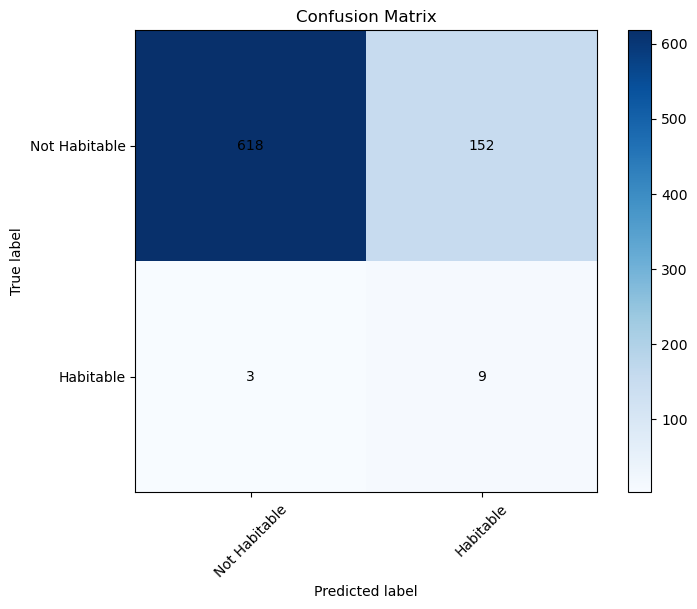

In [471]:
import matplotlib.pyplot as plt
import numpy as np


y_pred = model_best_features.predict(X_test_5)
# Print confusion matrix for best model
cm = confusion_matrix(y_test_5, y_pred)
print(f'Confusion Matrix:\n{cm}\n')

# Plot confusion matrix with values in the boxes
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Habitable', 'Habitable'], rotation=45)
plt.yticks(tick_marks, ['Not Habitable', 'Habitable'])

plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()


## 5.2 Grid Search

Confusion Matrix:
[[762   8]
 [  5   7]]



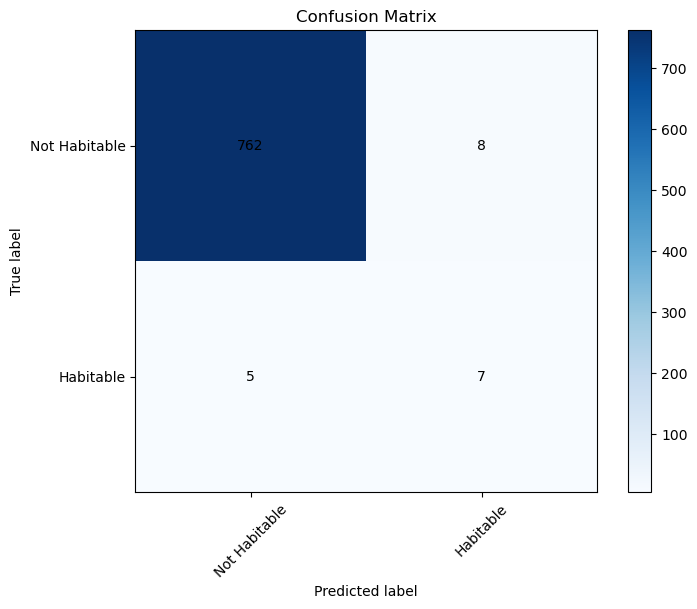

In [472]:
y_pred = model_best_grid.predict(X_test_5)
# Print confusion matrix for best model
cm = confusion_matrix(y_test_5, y_pred)
print(f'Confusion Matrix:\n{cm}\n')

# Plot confusion matrix with values in the boxes
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Habitable', 'Habitable'], rotation=45)
plt.yticks(tick_marks, ['Not Habitable', 'Habitable'])

plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()

## Results

Overall, the model based on Grid Search performs significantly better than the model that has been tuned based on the individually best performing parameters. Overall a macro average F1 score of 76% is reached in the test data with this resulting model. 

# 6. Run time Complexity

In [474]:
import time

# Initialize a dictionary to store training and prediction times
training_times = {}

# Start measuring time for training
start_time = time.time()
model_best_grid.fit(X_train_5, y_train_5)  # Train the model
end_time = time.time()

# Calculate training duration
training_duration = end_time - start_time

# Start measuring time for prediction
start_time = time.time()
predictions = model_best_grid.predict(X_test_5)
prediction_time = time.time() - start_time

# Store times in the dictionary
training_times['Decision Tree'] = {'Training Time': training_duration, 'Prediction Time': prediction_time}

# Print the times
print(f"Decision Tree training time: {training_duration:.2f} seconds")
print(f"Decision Tree prediction time: {prediction_time:.2f} seconds")

Decision Tree training time: 0.10 seconds
Decision Tree prediction time: 0.01 seconds
